# 测试

In [1]:
import torch
from torch import nn, fx, optim
from torch.nn import functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from torch.ao.quantization import observer
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.data.simple_vision import load_data_cifar10
from torch_book.tools import train, try_all_gpus #try_gpu
from torch_book.tools import evaluate_accuracy
# from fixed_sigmoid import linear_sigmoid
from fit_sigmoid import sigmoid2linear


torch.cuda.empty_cache() # 清空 GPU 缓存

batch_size = 32
train_iter, test_iter = load_data_cifar10(batch_size=batch_size)
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                        model.conv1.out_channels, 
                        3, 1, 1)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)

# 替换 ReLU 为 torch.sigmoid
mod = fx.symbolic_trace(model)
# 遍历 Graph 中全部节点
for node in mod.graph.nodes:
    # 如果匹配目标
    if node.op == "call_module":
        if "relu" in node.target:
            # 设置插入点，添加新节点，用新节点替换所有 `node` 的用法
            with mod.graph.inserting_after(node):
                new_node = mod.graph.call_function(torch.sigmoid, node.args, node.kwargs)
                node.replace_all_uses_with(new_node)
            # 移除 graph 中旧的节点
            mod.graph.erase_node(node)
mod.graph.lint()
# 不用忘记 recompile!
new_code = mod.recompile()

# 加载模型参数
state_dict = torch.load("models/resnet18_cifar10_sigmoid.h5")
mod.load_state_dict(state_dict)

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [2]:
valid_acc = evaluate_accuracy(mod, test_iter)
valid_acc

0.8407

In [3]:
# from fixed_sigmoid import linear_sigmoid
# 遍历 Graph 中全部节点
for node in mod.graph.nodes:
    # 如果匹配目标
    if node.op == "call_function":
        # if node.name == "sigmoid":
        if "sigmoid" in node.name:
            node.target = sigmoid2linear
            print(node.name, node.target)
mod.graph.lint()
# 不用忘记 recompile!
new_code = mod.recompile()

sigmoid <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_1 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_2 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_3 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_4 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_5 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_6 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_7 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_8 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_9 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_10 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_11 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_12 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_13 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_14 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_15 <function sigmoid2linear at 0x7f8d473505e0>
sigmoid_16 <function sigmoid2linear at 0x7f8d473505e0>


In [4]:
valid_acc = evaluate_accuracy(mod, test_iter)
valid_acc

0.1243

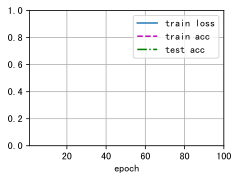

In [5]:
lr, num_epochs = 0.00142857, 100
weight_decay = 0.0007142857142857143
momentum = 0.857142
lr_period = 4
lr_decay = 0.857142
devices = try_all_gpus()
optimizer = optim.SGD(mod.parameters(),
                      lr=lr, 
                      momentum=momentum, 
                      weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=lr_period, 
                                      gamma=lr_decay)
train(mod, train_iter, test_iter,
      num_epochs, devices,
      optimizer, scheduler)